In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
##### LOAD #########
# choose load file name
data_path_train="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/train_23_lang/"
data_path_test="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/test_23_lang/"
f1 = data_path_train+'X_train_IIITH_23L_original_mfcc_cms.npy'
f2 = data_path_train+'y_train_IIITH_23L_original_mfcc_cms.npy'
#f3 = data_path+'X_train_AUG-10-15-25-35-40-45-50_IIITH_23L_MFCC_cms_new.npy'
#f4 = data_path+'y_train_AUG-10-15-25-35-40-45-50_IIITH_23L_MFCC_cms_new.npy'
f5 = data_path_test+'X_test_IIITH_23L_original_mfcc_cms.npy'
f6 = data_path_test+'y_test_IIITH_23L_original_mfcc_cms.npy'

X_train = np.load(f1)
#X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5)
y_train = np.load(f2,allow_pickle=True)
#y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
#print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(80048, 300, 20), y_train:(80048,)
X_valid:(23137, 300, 20), y_valid:(23137,)


In [3]:
print(np.unique(y_train,return_counts=True))
#print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int16), array([3223, 3715, 3857, 2946, 3232, 3255, 3331, 4178, 3066, 3404, 3404,
       3897, 3473, 3707, 3378, 3318, 3665, 3081, 4495, 3350, 3621, 3837,
       2615]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int16), array([1052,  834, 1031, 1233, 1036,  979, 1077, 1275,  953, 1239,  879,
       1055, 1178,  779, 1200, 1020, 1026,  921,  903,  456, 1163, 1314,
        534]))


In [4]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(80048, 300, 20)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int16), array([3223, 3715, 3857, 2946, 3232, 3255, 3331, 4178, 3066, 3404, 3404,
       3897, 3473, 3707, 3378, 3318, 3665, 3081, 4495, 3350, 3621, 3837,
       2615]))


In [5]:
import torch
import torch.nn as nn
from conformer import Conformer

cuda = torch.cuda.is_available()  
device = torch.device('cuda' if cuda else 'cpu')

class Conformer_sd21(nn.Module):
    def __init__(self, input_dim = 20, num_classes=5):
        super(Conformer_sd21, self).__init__()
        self.conformer = Conformer(num_classes= 40, 
                      input_dim= input_dim, 
                      encoder_dim=64, 
                      num_encoder_layers=10)
        self.fc1 = nn.Linear(80, 512)
        self.fc2 = nn.Linear(512,512)
        self.drop = nn.Dropout(0.15)
        self.nonlinearity=nn.ReLU()
        self.bn = nn.BatchNorm1d(512)
        self.output = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,inputs,input_lengths):
        conf_output,_ = self.conformer(inputs,input_lengths)
        #print(conf_output.shape)
        conf_mean_output = torch.mean(conf_output,axis=1)
        conf_std_output = torch.std(conf_output,axis=1)
        conf = torch.cat((conf_mean_output,conf_std_output),axis=1)
        #print(conf.shape)
        x = conf.reshape(conf.shape[0],-1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.nonlinearity(x)
        x = self.bn(x)
        x = self.drop(x)
#         x = self.fc2(x)
#         x = self.nonlinearity(x)
#         x = self.bn(x)
#         x = self.drop(x)
        predictions = self.output(x)
        final_pred = self.softmax(predictions)
        return conf_output, predictions, final_pred        

In [6]:
def xv_data_manage(X_test):
    aa=X_test.transpose((0,2,1))
    print(X_test.shape, '-->', aa.shape)
    return aa

In [7]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [8]:
class_weights_train=imbalance_class_weight(y_train,23)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 3223
1 ---> 3715
2 ---> 3857
3 ---> 2946
4 ---> 3232
5 ---> 3255
6 ---> 3331
7 ---> 4178
8 ---> 3066
9 ---> 3404
10 ---> 3404
11 ---> 3897
12 ---> 3473
13 ---> 3707
14 ---> 3378
15 ---> 3318
16 ---> 3665
17 ---> 3081
18 ---> 4495
19 ---> 3350
20 ---> 3621
21 ---> 3837
22 ---> 2615
[1.07984729 0.93683656 0.90234582 1.1813808  1.07684029 1.06923128
 1.04483573 0.83301767 1.1351428  1.02242886 1.02242886 0.89308387
 1.0021157  0.93885833 1.03029835 1.04892942 0.94961742 1.1296163
 0.77427093 1.0389098  0.96115654 0.90704921 1.33091695]
[0.81135588 0.7039031  0.67798807 0.88764426 0.80909653 0.80337942
 0.78504953 0.62589756 0.8529028  0.76821387 0.76821387 0.671029
 0.75295134 0.70542217 0.7741267  0.78812538 0.71350614 0.84875041
 0.58175751 0.78059701 0.72217619 0.68152202 1.        ]


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = Conformer_sd21(20,23).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

267
724


In [11]:
np.unique(y_valid,return_counts =True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int16),
 array([1052,  834, 1031, 1233, 1036,  979, 1077, 1275,  953, 1239,  879,
        1055, 1178,  779, 1200, 1020, 1026,  921,  903,  456, 1163, 1314,
         534]))

Epoch: 0, Batch: 0, Loss: 3.13783860206604, Accuracy:4.666666666666667%
Epoch: 0, Batch: 50, Loss: 3.0603857040405273, Accuracy:15.333333333333332%
Epoch: 0, Batch: 100, Loss: 3.0449390411376953, Accuracy:16.0%
Epoch: 0, Batch: 150, Loss: 2.919901132583618, Accuracy:30.333333333333336%
Epoch: 0, Batch: 200, Loss: 2.94596266746521, Accuracy:26.333333333333332%
Epoch: 0, Batch: 250, Loss: 2.8778843879699707, Accuracy:35.333333333333336%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 3.196399450302124, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 3.076901435852051, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 3.1928443908691406, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 150, Loss: 2.7784218788146973, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 0, Batch: 200, Loss: 3.195274829864502, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 250, Loss: 2.8973331451416016, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 0, Bat

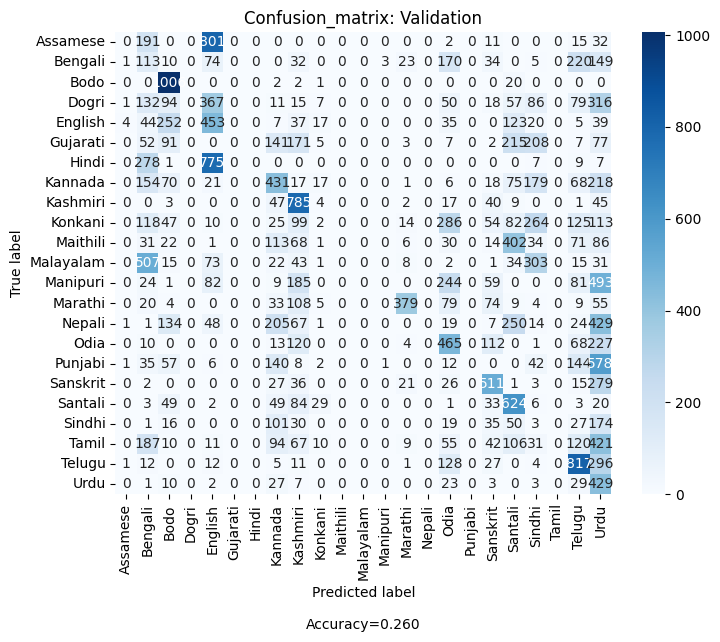

:::::Total vlidation loss 2.948965314014182, Training accuracy 0.2261143314011593, Validation accuracy 0.2601028655400441 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 2.919663906097412, Accuracy:28.666666666666668%
Epoch: 1, Batch: 50, Loss: 2.8653810024261475, Accuracy:35.66666666666667%
Epoch: 1, Batch: 100, Loss: 2.8742010593414307, Accuracy:34.66666666666667%
Epoch: 1, Batch: 150, Loss: 2.877139091491699, Accuracy:32.33333333333333%
Epoch: 1, Batch: 200, Loss: 2.8633310794830322, Accuracy:34.0%
Epoch: 1, Batch: 250, Loss: 2.7906265258789062, Accuracy:42.333333333333336%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 3.179013967514038, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 2.655294418334961, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 3.199469566345215, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 1, Batch: 150, Loss: 2.743126630783081, Accuracy:46.875%
#####TEST--

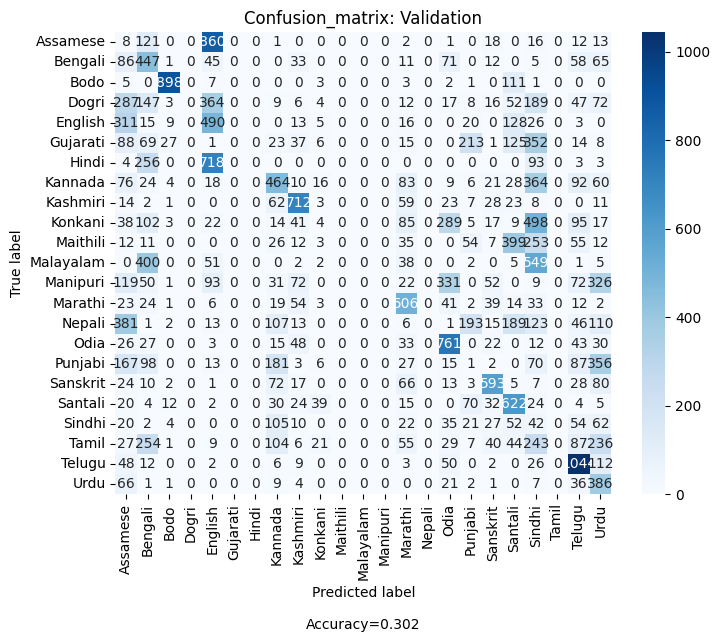

:::::Total vlidation loss 2.9074522536762513, Training accuracy 0.36702978213072157, Validation accuracy 0.30159484807883474 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 2.7762866020202637, Accuracy:44.333333333333336%
Epoch: 2, Batch: 50, Loss: 2.791311740875244, Accuracy:43.0%
Epoch: 2, Batch: 100, Loss: 2.768665313720703, Accuracy:45.0%
Epoch: 2, Batch: 150, Loss: 2.80082106590271, Accuracy:40.666666666666664%
Epoch: 2, Batch: 200, Loss: 2.7852468490600586, Accuracy:43.666666666666664%
Epoch: 2, Batch: 250, Loss: 2.6989824771881104, Accuracy:51.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 3.1845264434814453, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 2.785975217819214, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 3.2019402980804443, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 150, Loss: 2.728199005126953, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 2, Ba

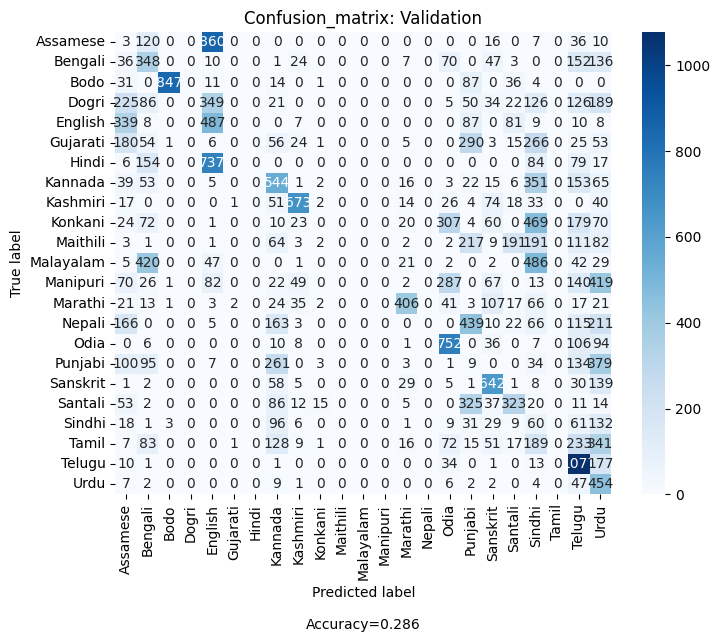

:::::Total vlidation loss 2.9186355521007137, Training accuracy 0.41641265240855485, Validation accuracy 0.28633790033280027 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 2.8158090114593506, Accuracy:39.0%
Epoch: 3, Batch: 50, Loss: 2.779393434524536, Accuracy:43.666666666666664%
Epoch: 3, Batch: 100, Loss: 2.7603704929351807, Accuracy:45.666666666666664%
Epoch: 3, Batch: 150, Loss: 2.7730612754821777, Accuracy:44.666666666666664%
Epoch: 3, Batch: 200, Loss: 2.7812867164611816, Accuracy:43.666666666666664%
Epoch: 3, Batch: 250, Loss: 2.737755537033081, Accuracy:47.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 3.198077917098999, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 2.886575698852539, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 3.2019693851470947, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 150, Loss: 2.615330934524536, Accuracy:62.5%
#####TEST--in-domain::

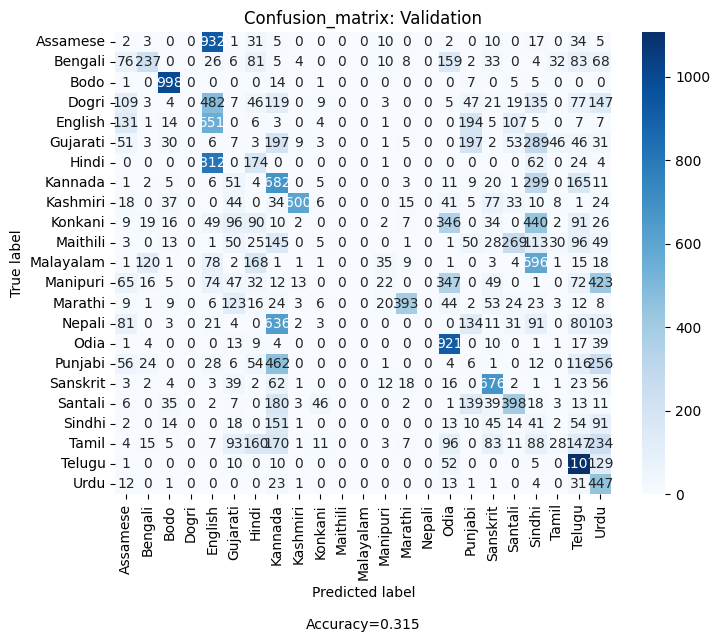

:::::Total vlidation loss 2.889761823975579, Training accuracy 0.44714421347191685, Validation accuracy 0.31507974240394176 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 2.7570102214813232, Accuracy:46.33333333333333%
Epoch: 4, Batch: 50, Loss: 2.783169746398926, Accuracy:42.66666666666667%
Epoch: 4, Batch: 100, Loss: 2.741344690322876, Accuracy:49.0%
Epoch: 4, Batch: 150, Loss: 2.743680000305176, Accuracy:46.33333333333333%
Epoch: 4, Batch: 200, Loss: 2.7250566482543945, Accuracy:50.33333333333333%
Epoch: 4, Batch: 250, Loss: 2.7089433670043945, Accuracy:50.33333333333333%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 3.193382978439331, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 2.636019706726074, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 3.2020270824432373, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 150, Loss: 2.650853157043457, Accuracy:53.125%
#####TEST--in

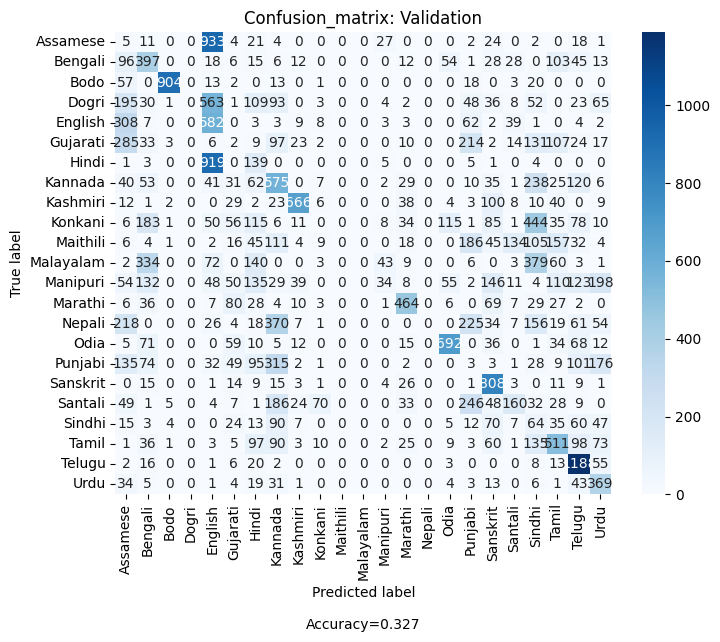

:::::Total vlidation loss 2.8786641109055577, Training accuracy 0.48600839496302217, Validation accuracy 0.3268790249384103 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 2.748828411102295, Accuracy:46.0%
Epoch: 5, Batch: 50, Loss: 2.753514051437378, Accuracy:46.0%
Epoch: 5, Batch: 100, Loss: 2.710970640182495, Accuracy:49.0%
Epoch: 5, Batch: 150, Loss: 2.7266921997070312, Accuracy:48.66666666666667%
Epoch: 5, Batch: 200, Loss: 2.7014660835266113, Accuracy:51.33333333333333%
Epoch: 5, Batch: 250, Loss: 2.6534690856933594, Accuracy:56.99999999999999%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 3.186499834060669, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 2.6187827587127686, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 3.2019312381744385, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 150, Loss: 2.8268771171569824, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 5, Ba

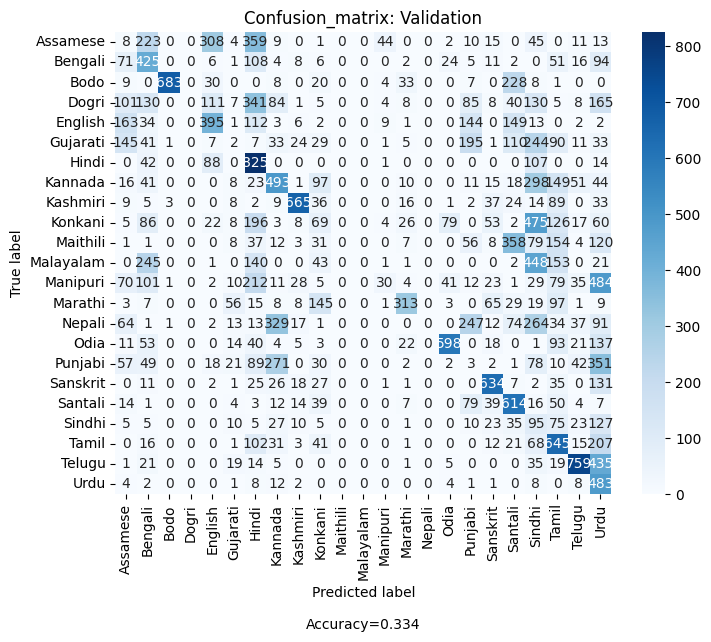

:::::Total vlidation loss 2.873519948503589, Training accuracy 0.5083325004997001, Validation accuracy 0.3344858884038553 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 2.756812572479248, Accuracy:47.0%
Epoch: 6, Batch: 50, Loss: 2.7085421085357666, Accuracy:49.666666666666664%
Epoch: 6, Batch: 100, Loss: 2.714021682739258, Accuracy:49.333333333333336%
Epoch: 6, Batch: 150, Loss: 2.6720058917999268, Accuracy:54.333333333333336%
Epoch: 6, Batch: 200, Loss: 2.66440749168396, Accuracy:54.333333333333336%
Epoch: 6, Batch: 250, Loss: 2.6934547424316406, Accuracy:51.33333333333333%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 3.197596311569214, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 2.618797540664673, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 3.2032697200775146, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 150, Loss: 2.5029044151306152, Accuracy:68.75%
#####TEST--i

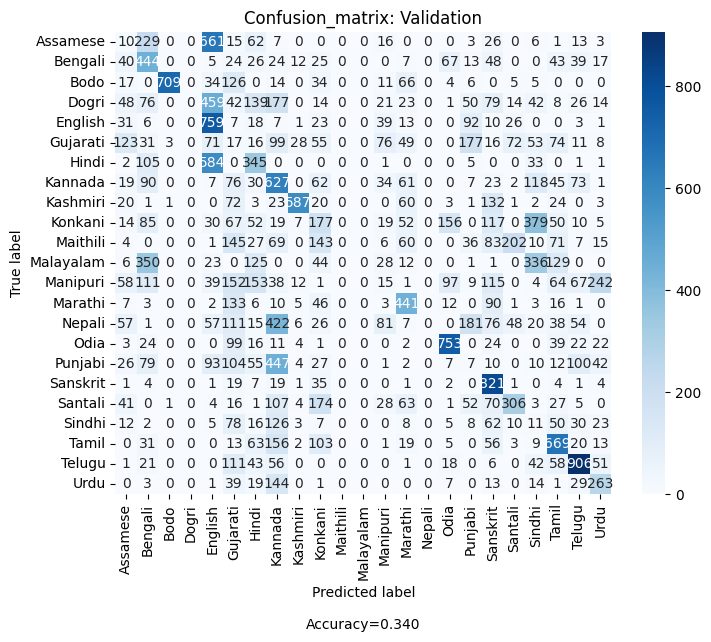

:::::Total vlidation loss 2.865299196862384, Training accuracy 0.5328802718368979, Validation accuracy 0.34001815274236075 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 2.6588637828826904, Accuracy:54.666666666666664%
Epoch: 7, Batch: 50, Loss: 2.710698366165161, Accuracy:50.66666666666667%
Epoch: 7, Batch: 100, Loss: 2.639246940612793, Accuracy:55.666666666666664%
Epoch: 7, Batch: 150, Loss: 2.6553876399993896, Accuracy:56.333333333333336%
Epoch: 7, Batch: 200, Loss: 2.6640548706054688, Accuracy:53.666666666666664%
Epoch: 7, Batch: 250, Loss: 2.6772255897521973, Accuracy:54.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 3.107168197631836, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 2.781315565109253, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 3.200357437133789, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 150, Loss: 2.63311767578125, Accuracy:62.5%
#####TEST--

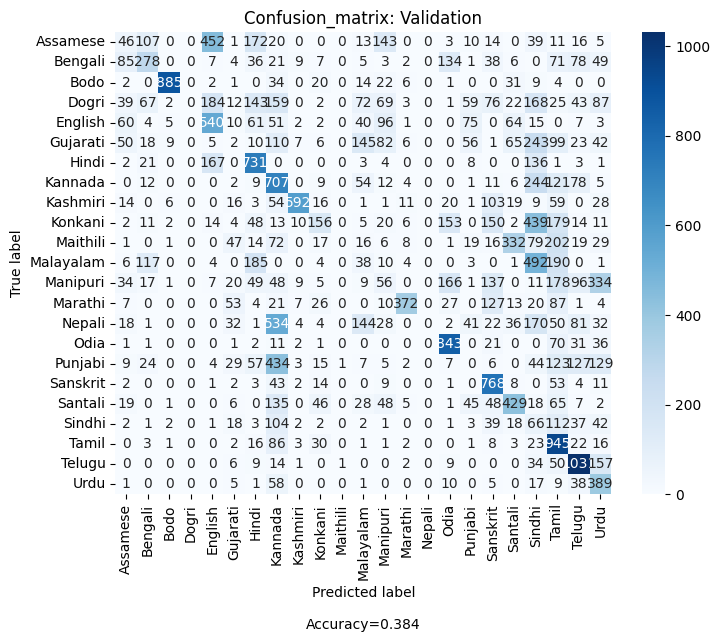

:::::Total vlidation loss 2.822706070723455, Training accuracy 0.5495827503497901, Validation accuracy 0.38354151359294636 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 2.6202356815338135, Accuracy:59.0%
Epoch: 8, Batch: 50, Loss: 2.6488077640533447, Accuracy:56.666666666666664%
Epoch: 8, Batch: 100, Loss: 2.639662027359009, Accuracy:58.333333333333336%
Epoch: 8, Batch: 150, Loss: 2.63464617729187, Accuracy:57.99999999999999%
Epoch: 8, Batch: 200, Loss: 2.6591732501983643, Accuracy:55.333333333333336%
Epoch: 8, Batch: 250, Loss: 2.6067190170288086, Accuracy:61.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 3.204812526702881, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 2.5004422664642334, Accuracy:68.75%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 3.2037951946258545, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 150, Loss: 2.3235626220703125, Accuracy:90.625%
#####TEST--in-domain:::

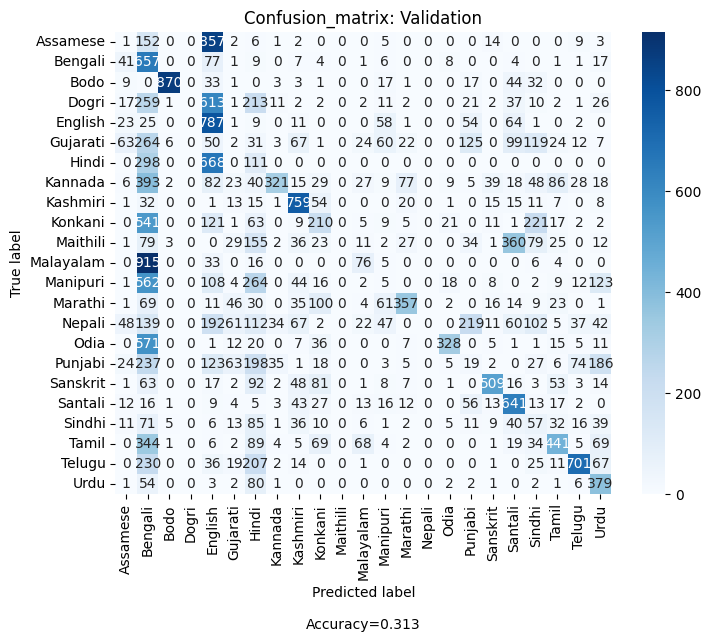

:::::Total vlidation loss 2.8918244644423217, Training accuracy 0.5703827703377973, Validation accuracy 0.3125297143104119 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 2.6434993743896484, Accuracy:56.99999999999999%
Epoch: 9, Batch: 50, Loss: 2.6494016647338867, Accuracy:56.666666666666664%
Epoch: 9, Batch: 100, Loss: 2.654160737991333, Accuracy:56.00000000000001%
Epoch: 9, Batch: 150, Loss: 2.6387712955474854, Accuracy:57.99999999999999%
Epoch: 9, Batch: 200, Loss: 2.6677093505859375, Accuracy:55.00000000000001%
Epoch: 9, Batch: 250, Loss: 2.659679889678955, Accuracy:56.00000000000001%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 3.2003259658813477, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 2.6193811893463135, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 3.2029058933258057, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 150, Loss: 2.714906692504883, Accuracy:46.87

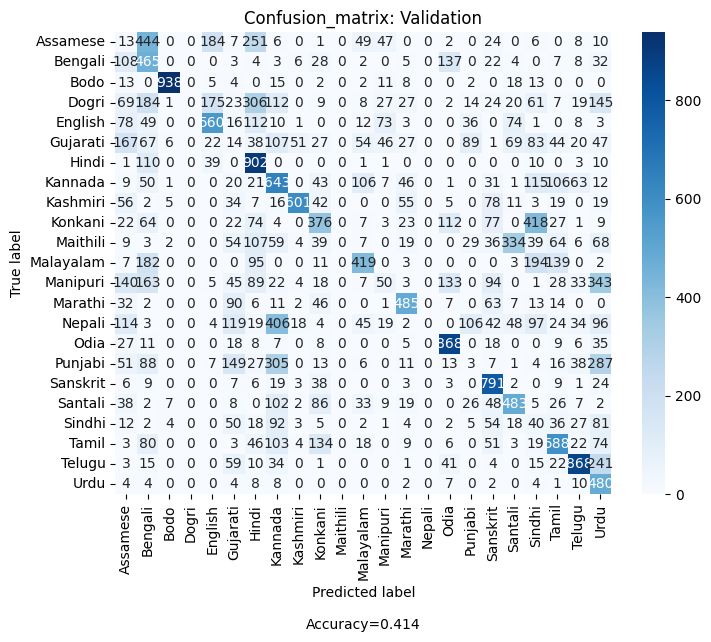

:::::Total vlidation loss 2.7937538771998156, Training accuracy 0.5844743154107536, Validation accuracy 0.4143579547910274 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 2.6730306148529053, Accuracy:54.333333333333336%
Epoch: 10, Batch: 50, Loss: 2.6236531734466553, Accuracy:59.333333333333336%
Epoch: 10, Batch: 100, Loss: 2.626117706298828, Accuracy:59.0%
Epoch: 10, Batch: 150, Loss: 2.6706409454345703, Accuracy:54.666666666666664%
Epoch: 10, Batch: 200, Loss: 2.5972461700439453, Accuracy:61.66666666666667%
Epoch: 10, Batch: 250, Loss: 2.6164753437042236, Accuracy:59.66666666666667%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 3.1653249263763428, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 2.559872627258301, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 3.2018492221832275, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 150, Loss: 2.323749303817749, Accuracy:90.625

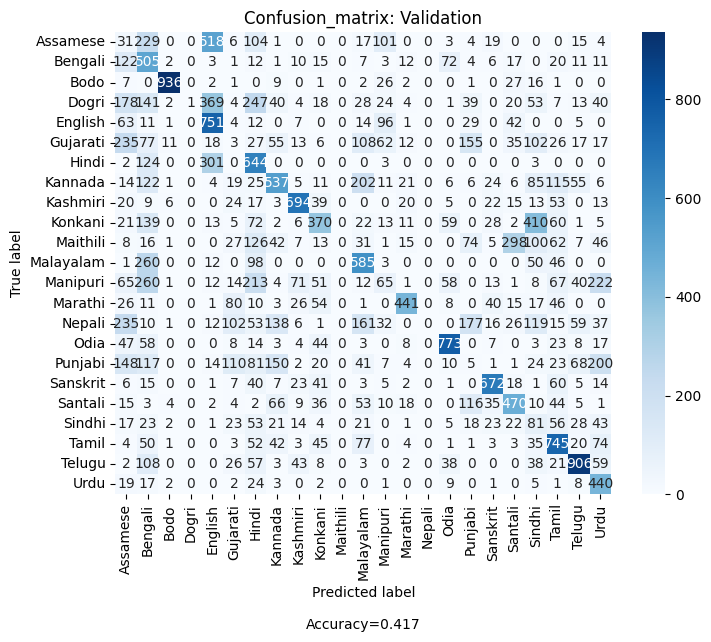

:::::Total vlidation loss 2.7886324047383684, Training accuracy 0.5990780531680991, Validation accuracy 0.4172969702208584 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 2.5990428924560547, Accuracy:61.66666666666667%
Epoch: 11, Batch: 50, Loss: 2.5610694885253906, Accuracy:64.33333333333333%
Epoch: 11, Batch: 100, Loss: 2.6001384258270264, Accuracy:61.66666666666667%
Epoch: 11, Batch: 150, Loss: 2.643031120300293, Accuracy:56.666666666666664%
Epoch: 11, Batch: 200, Loss: 2.6024868488311768, Accuracy:61.0%
Epoch: 11, Batch: 250, Loss: 2.5883543491363525, Accuracy:63.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 3.1209957599639893, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 2.4697160720825195, Accuracy:75.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 3.170886754989624, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 11, Batch: 150, Loss: 2.548792839050293, Accuracy:62.5%
#####TEST--i

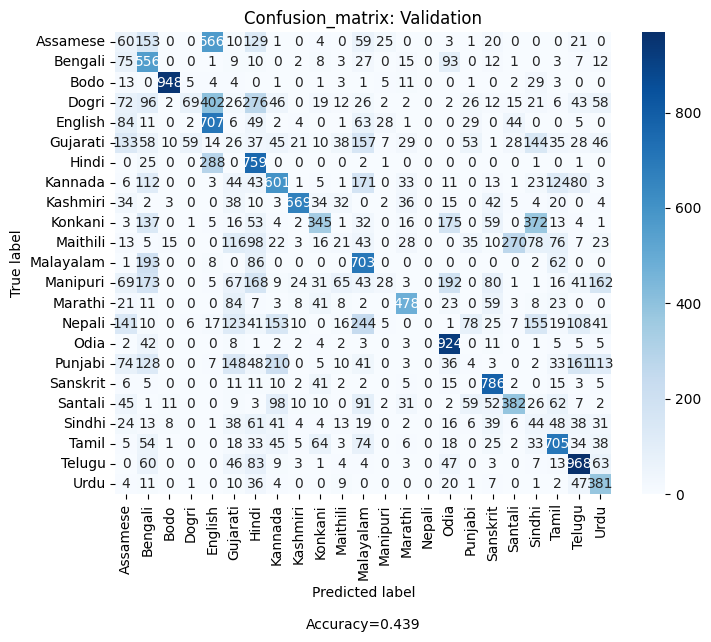

:::::Total vlidation loss 2.767560190258764, Training accuracy 0.614069058564861, Validation accuracy 0.43929636512944636 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 2.592200756072998, Accuracy:62.33333333333333%
Epoch: 12, Batch: 50, Loss: 2.573591947555542, Accuracy:65.0%
Epoch: 12, Batch: 100, Loss: 2.542738199234009, Accuracy:67.33333333333333%
Epoch: 12, Batch: 150, Loss: 2.5940325260162354, Accuracy:61.33333333333333%
Epoch: 12, Batch: 200, Loss: 2.5443601608276367, Accuracy:67.66666666666666%
Epoch: 12, Batch: 250, Loss: 2.5582211017608643, Accuracy:65.33333333333333%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 2.9314591884613037, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 2.5186805725097656, Accuracy:68.75%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 3.1033689975738525, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 12, Batch: 150, Loss: 2.945167064666748, Accuracy:28.125%
#

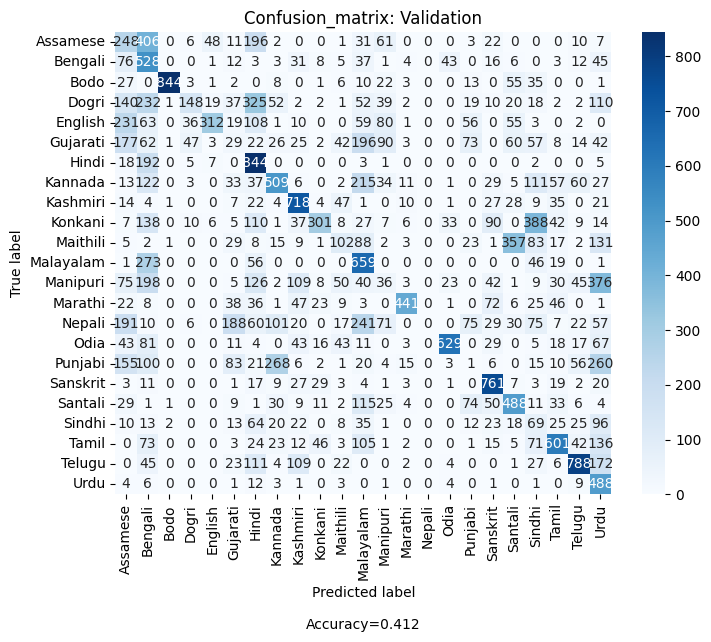

:::::Total vlidation loss 2.793187371275043, Training accuracy 0.6282605436737957, Validation accuracy 0.41249945973981067 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 2.618891716003418, Accuracy:60.0%
Epoch: 13, Batch: 50, Loss: 2.5600178241729736, Accuracy:66.0%
Epoch: 13, Batch: 100, Loss: 2.5726072788238525, Accuracy:64.66666666666666%
Epoch: 13, Batch: 150, Loss: 2.533705472946167, Accuracy:68.33333333333333%
Epoch: 13, Batch: 200, Loss: 2.573439121246338, Accuracy:65.33333333333333%
Epoch: 13, Batch: 250, Loss: 2.5694446563720703, Accuracy:64.33333333333333%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 3.0122015476226807, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 2.8625800609588623, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 3.1315746307373047, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 13, Batch: 150, Loss: 2.450103521347046, Accuracy:78.125%
#####TEST--

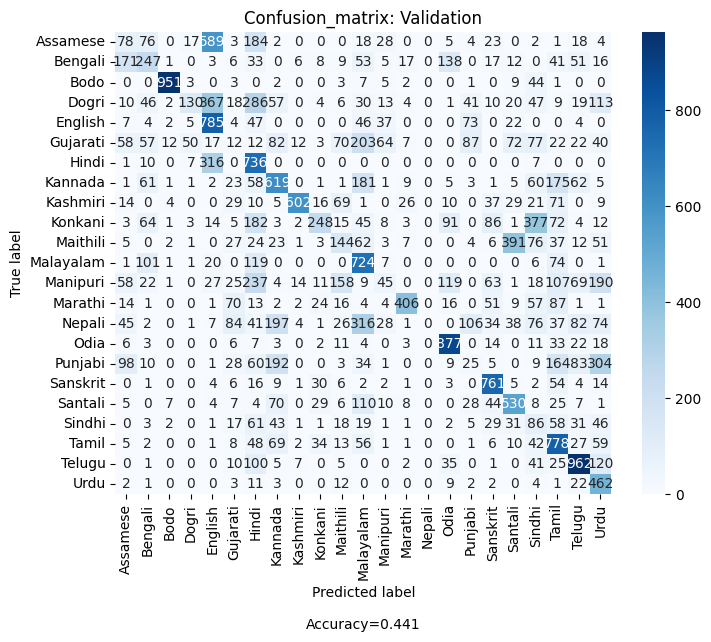

:::::Total vlidation loss 2.765925547036018, Training accuracy 0.6422896262242654, Validation accuracy 0.4411980809958076 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 2.5729808807373047, Accuracy:64.33333333333333%
Epoch: 14, Batch: 50, Loss: 2.4981491565704346, Accuracy:71.66666666666667%
Epoch: 14, Batch: 100, Loss: 2.532064199447632, Accuracy:68.0%
Epoch: 14, Batch: 150, Loss: 2.542005777359009, Accuracy:67.66666666666666%
Epoch: 14, Batch: 200, Loss: 2.5257408618927, Accuracy:69.33333333333334%
Epoch: 14, Batch: 250, Loss: 2.5638370513916016, Accuracy:64.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 3.0934860706329346, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 2.5921897888183594, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 3.1328155994415283, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 14, Batch: 150, Loss: 2.4613428115844727, Accuracy:75.0%
#####TEST--in-do

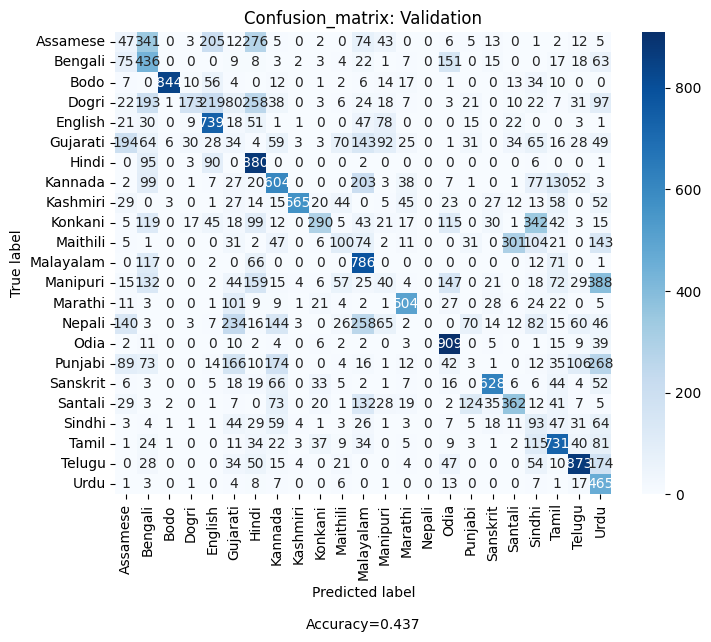

:::::Total vlidation loss 2.769000135732619, Training accuracy 0.6550819508295023, Validation accuracy 0.43678955785106105 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 2.546178102493286, Accuracy:66.66666666666666%
Epoch: 15, Batch: 50, Loss: 2.5315093994140625, Accuracy:68.33333333333333%
Epoch: 15, Batch: 100, Loss: 2.5745415687561035, Accuracy:64.66666666666666%
Epoch: 15, Batch: 150, Loss: 2.5117244720458984, Accuracy:70.66666666666667%
Epoch: 15, Batch: 200, Loss: 2.543656826019287, Accuracy:66.33333333333333%
Epoch: 15, Batch: 250, Loss: 2.5625510215759277, Accuracy:65.33333333333333%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 2.8020458221435547, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 2.649015188217163, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 3.1467878818511963, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 15, Batch: 150, Loss: 2.467298984527588, A

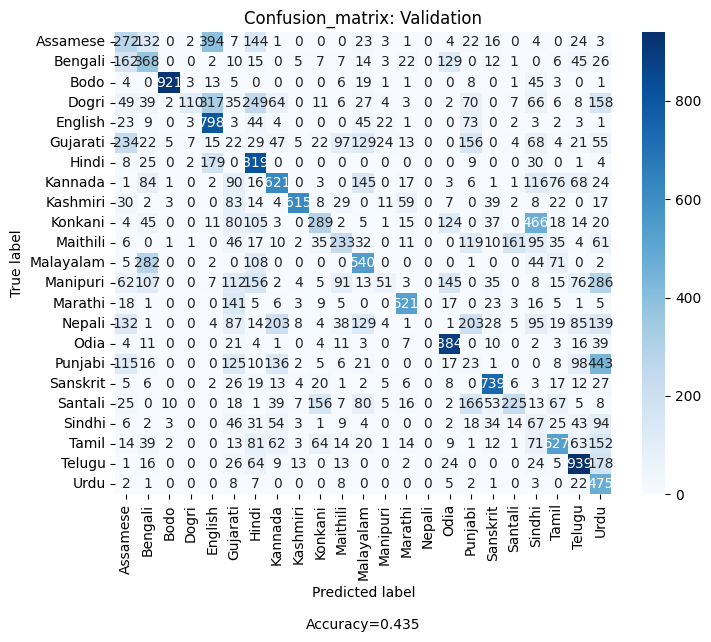

:::::Total vlidation loss 2.770506438300096, Training accuracy 0.6649510293823706, Validation accuracy 0.4347581795392661 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 2.5625216960906982, Accuracy:64.0%
Epoch: 16, Batch: 50, Loss: 2.5132968425750732, Accuracy:70.33333333333334%
Epoch: 16, Batch: 100, Loss: 2.5195980072021484, Accuracy:70.0%
Epoch: 16, Batch: 150, Loss: 2.562371253967285, Accuracy:65.33333333333333%
Epoch: 16, Batch: 200, Loss: 2.535630702972412, Accuracy:67.66666666666666%
Epoch: 16, Batch: 250, Loss: 2.5806548595428467, Accuracy:63.33333333333333%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 2.6908605098724365, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 2.8577373027801514, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 3.06085467338562, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 16, Batch: 150, Loss: 2.550851345062256, Accuracy:68.75%
#####TEST--

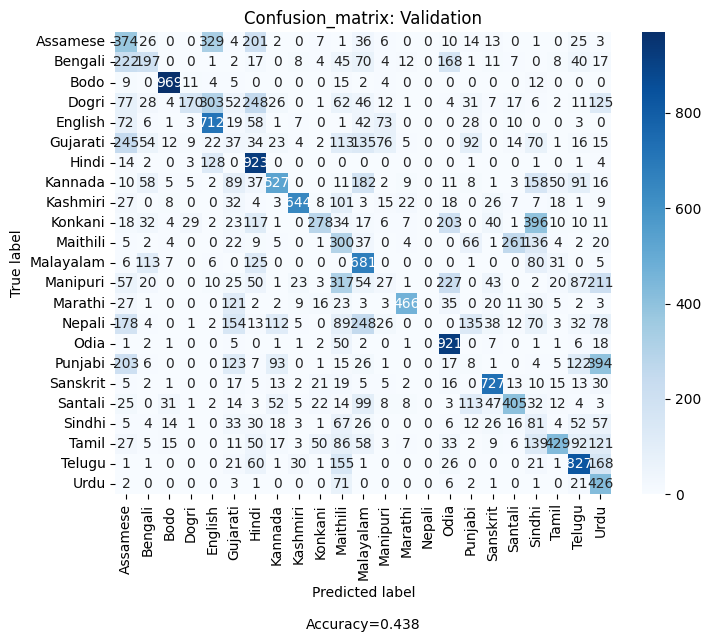

:::::Total vlidation loss 2.76826029554915, Training accuracy 0.6760193883669798, Validation accuracy 0.43778363659938624 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 2.5485379695892334, Accuracy:66.0%
Epoch: 17, Batch: 50, Loss: 2.530148983001709, Accuracy:68.66666666666667%
Epoch: 17, Batch: 100, Loss: 2.5511693954467773, Accuracy:66.33333333333333%
Epoch: 17, Batch: 150, Loss: 2.5169498920440674, Accuracy:69.0%
Epoch: 17, Batch: 200, Loss: 2.5199661254882812, Accuracy:69.0%
Epoch: 17, Batch: 250, Loss: 2.5588276386260986, Accuracy:65.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 2.7193639278411865, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 2.6534037590026855, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 3.094320058822632, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 17, Batch: 150, Loss: 2.4915263652801514, Accuracy:71.875%
#####TEST--in-domain:::::Epoch: 17,

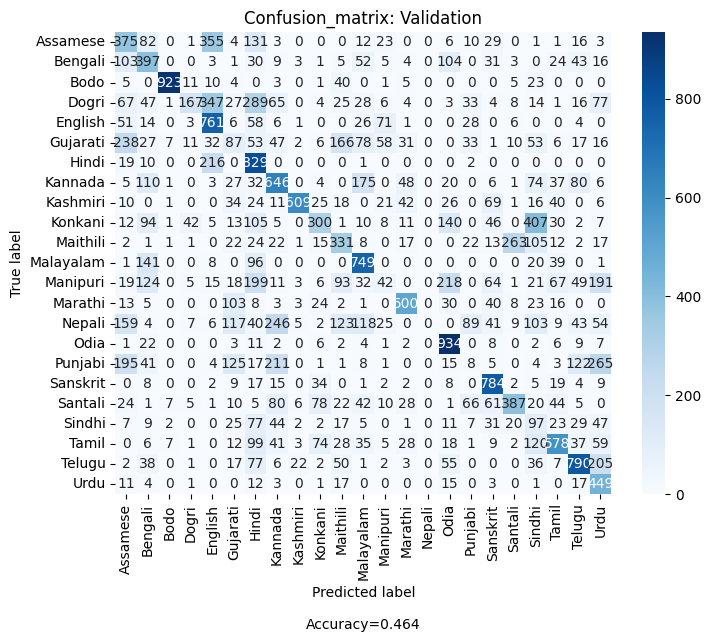

:::::Total vlidation loss 2.7418270282323847, Training accuracy 0.685638616829902, Validation accuracy 0.4643212170981545 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 2.5233118534088135, Accuracy:68.0%
Epoch: 18, Batch: 50, Loss: 2.566516876220703, Accuracy:65.66666666666666%
Epoch: 18, Batch: 100, Loss: 2.4622130393981934, Accuracy:75.0%
Epoch: 18, Batch: 150, Loss: 2.5073044300079346, Accuracy:71.0%
Epoch: 18, Batch: 200, Loss: 2.5256900787353516, Accuracy:67.33333333333333%
Epoch: 18, Batch: 250, Loss: 2.5457372665405273, Accuracy:66.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 2.8925108909606934, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 2.562751293182373, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 3.0996241569519043, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 18, Batch: 150, Loss: 2.4654541015625, Accuracy:71.875%
#####TEST--in-domain:::::Epoch: 18, Bat

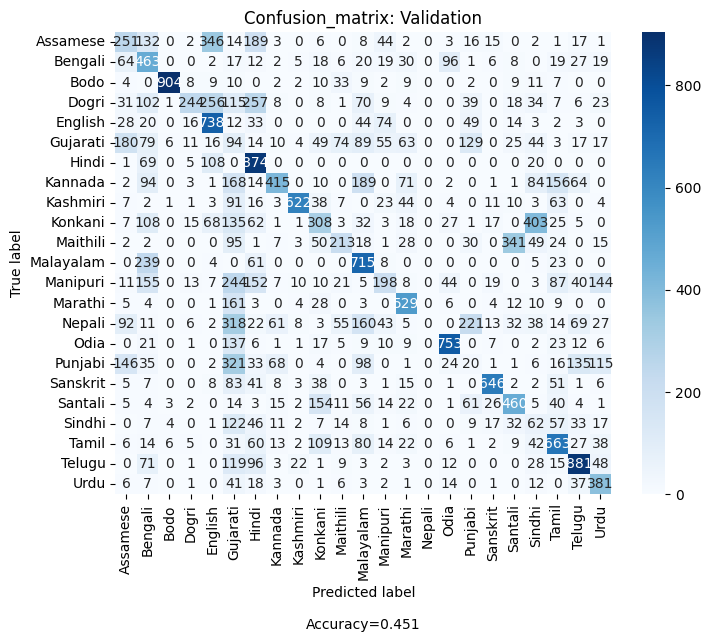

:::::Total vlidation loss 2.75556617975235, Training accuracy 0.6952328602838297, Validation accuracy 0.45096598521848125 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 2.509018659591675, Accuracy:71.66666666666667%
Epoch: 19, Batch: 50, Loss: 2.4987475872039795, Accuracy:71.0%
Epoch: 19, Batch: 100, Loss: 2.5198862552642822, Accuracy:69.66666666666667%
Epoch: 19, Batch: 150, Loss: 2.486799716949463, Accuracy:73.0%
Epoch: 19, Batch: 200, Loss: 2.489762544631958, Accuracy:71.66666666666667%
Epoch: 19, Batch: 250, Loss: 2.551809787750244, Accuracy:65.33333333333333%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 2.4968647956848145, Accuracy:71.875%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 2.731558084487915, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 3.0939693450927734, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 19, Batch: 150, Loss: 2.4694392681121826, Accuracy:75.0%
#####TEST--in-d

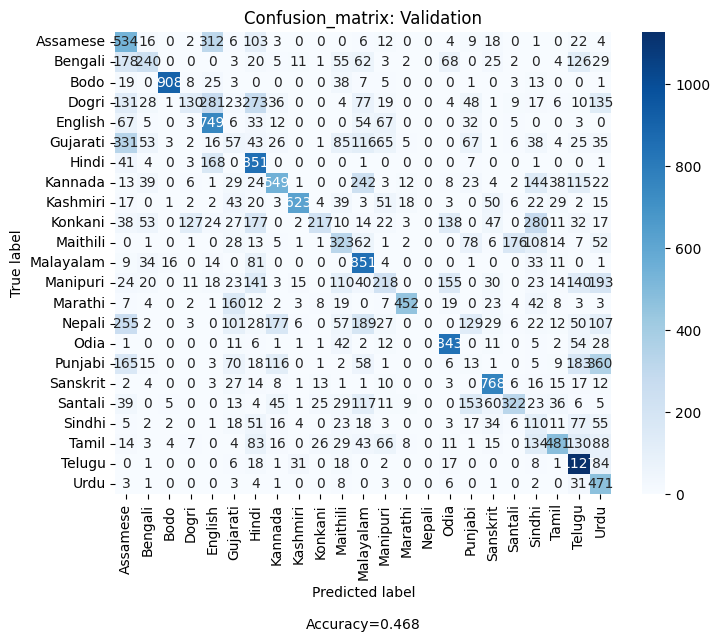

:::::Total vlidation loss 2.7376770801965704, Training accuracy 0.7051893863681791, Validation accuracy 0.4683839737217444 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 2.4522106647491455, Accuracy:76.0%
Epoch: 20, Batch: 50, Loss: 2.4984140396118164, Accuracy:70.66666666666667%
Epoch: 20, Batch: 100, Loss: 2.5319108963012695, Accuracy:67.66666666666666%
Epoch: 20, Batch: 150, Loss: 2.4903504848480225, Accuracy:71.66666666666667%
Epoch: 20, Batch: 200, Loss: 2.4979147911071777, Accuracy:71.0%
Epoch: 20, Batch: 250, Loss: 2.4550275802612305, Accuracy:75.66666666666667%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 2.625432252883911, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 2.569164514541626, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 3.0965402126312256, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 20, Batch: 150, Loss: 2.421297788619995, Accuracy:78.125%
#####TEST-

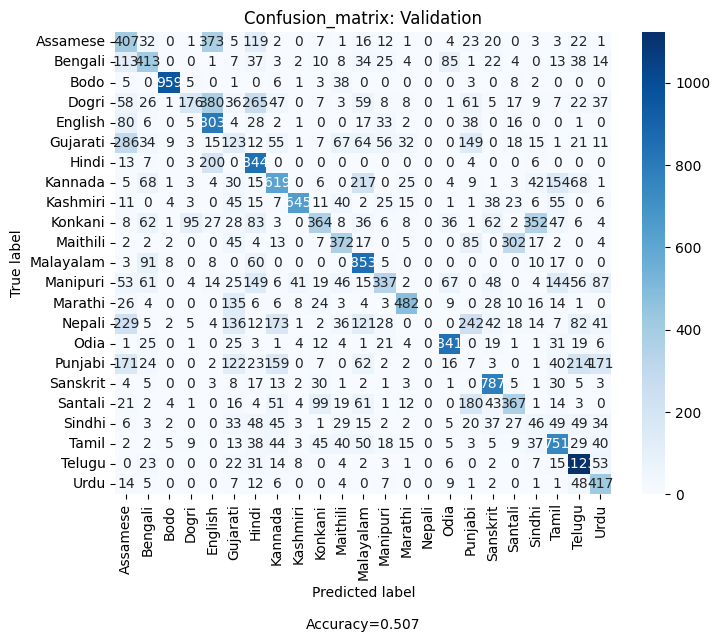

:::::Total vlidation loss 2.699734822162607, Training accuracy 0.7129472316610034, Validation accuracy 0.5072394865367161 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 2.5021488666534424, Accuracy:70.66666666666667%
Epoch: 21, Batch: 50, Loss: 2.459188222885132, Accuracy:75.0%
Epoch: 21, Batch: 100, Loss: 2.4601242542266846, Accuracy:75.0%
Epoch: 21, Batch: 150, Loss: 2.5151093006134033, Accuracy:70.33333333333334%
Epoch: 21, Batch: 200, Loss: 2.5079047679901123, Accuracy:71.0%
Epoch: 21, Batch: 250, Loss: 2.4832911491394043, Accuracy:73.66666666666667%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 2.9090609550476074, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 21, Batch: 50, Loss: 2.651048421859741, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 21, Batch: 100, Loss: 3.0365495681762695, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 21, Batch: 150, Loss: 2.613098382949829, Accuracy:59.375%
#####TEST--in-domain:::

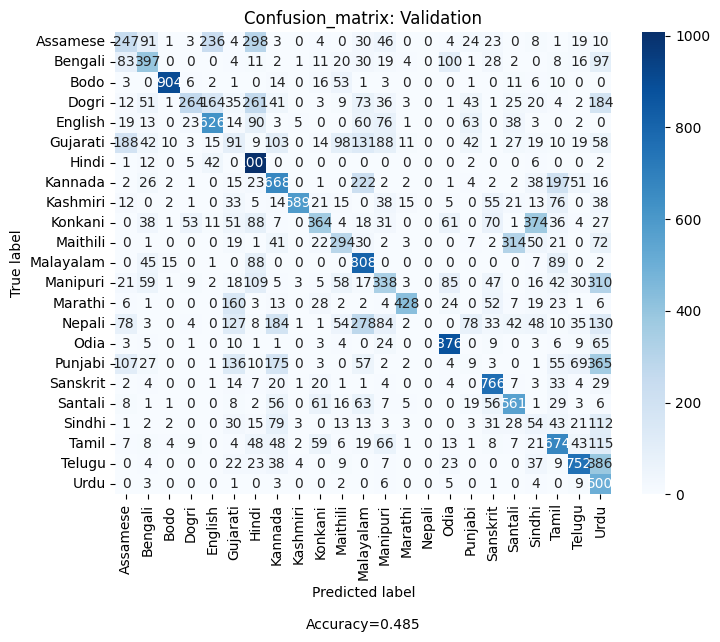

:::::Total vlidation loss 2.7220651816926607, Training accuracy 0.7200054967019788, Validation accuracy 0.48480788347668236 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 22, Batch: 0, Loss: 2.5219051837921143, Accuracy:69.0%
Epoch: 22, Batch: 50, Loss: 2.4422192573547363, Accuracy:77.0%
Epoch: 22, Batch: 100, Loss: 2.481656312942505, Accuracy:72.66666666666667%
Epoch: 22, Batch: 150, Loss: 2.482734441757202, Accuracy:72.0%
Epoch: 22, Batch: 200, Loss: 2.434014081954956, Accuracy:77.66666666666666%
Epoch: 22, Batch: 250, Loss: 2.4903781414031982, Accuracy:72.33333333333334%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 2.6807801723480225, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 22, Batch: 50, Loss: 2.6751933097839355, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 22, Batch: 100, Loss: 3.0449209213256836, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 22, Batch: 150, Loss: 2.4764089584350586, Accuracy:75.0%
#####TEST--in-domain::

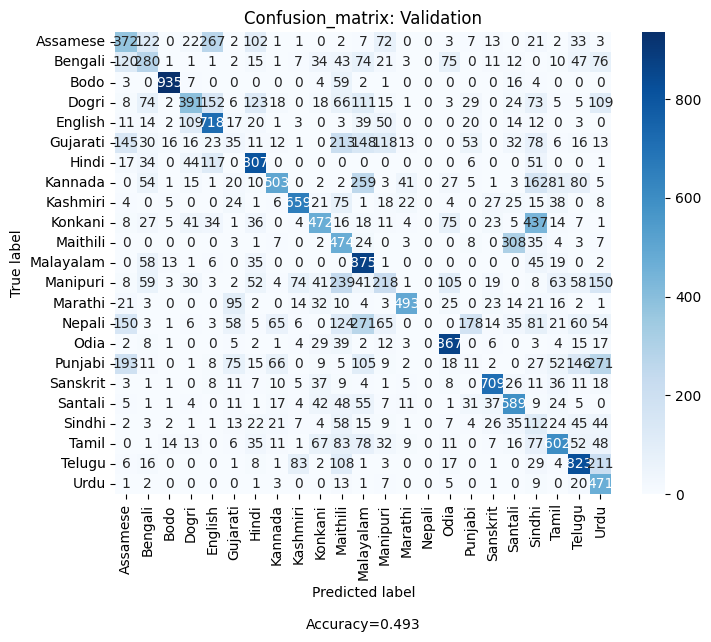

:::::Total vlidation loss 2.713763285407704, Training accuracy 0.7278757745352789, Validation accuracy 0.4934088256904525 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 2.4797651767730713, Accuracy:72.0%
Epoch: 23, Batch: 50, Loss: 2.5057246685028076, Accuracy:70.66666666666667%
Epoch: 23, Batch: 100, Loss: 2.4686994552612305, Accuracy:75.0%
Epoch: 23, Batch: 150, Loss: 2.484467029571533, Accuracy:73.0%
Epoch: 23, Batch: 200, Loss: 2.5124428272247314, Accuracy:68.33333333333333%
Epoch: 23, Batch: 250, Loss: 2.506901502609253, Accuracy:69.33333333333334%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 2.6416921615600586, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 23, Batch: 50, Loss: 2.6459898948669434, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 23, Batch: 100, Loss: 3.037336826324463, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 23, Batch: 150, Loss: 2.4084789752960205, Accuracy:78.125%
#####TEST--in-domain::

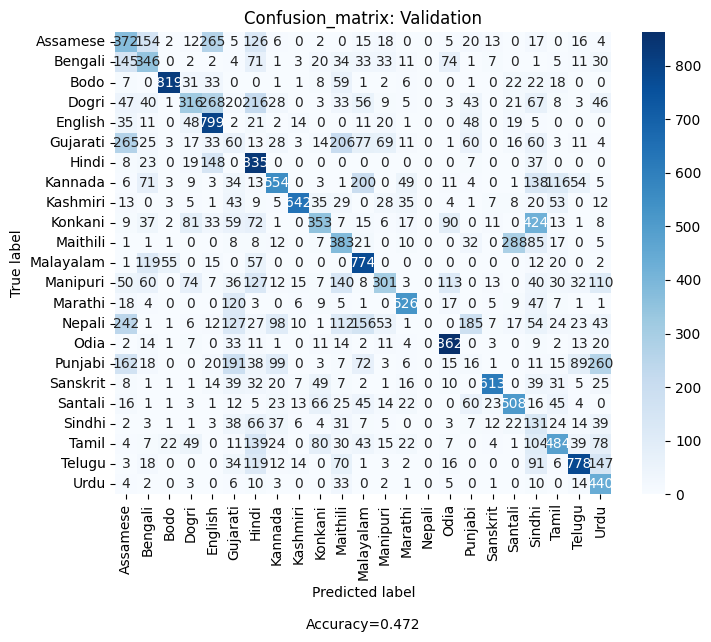

:::::Total vlidation loss 2.7341440017052117, Training accuracy 0.7336972816310214, Validation accuracy 0.4716255348575874 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 2.457183599472046, Accuracy:75.66666666666667%
Epoch: 24, Batch: 50, Loss: 2.4519450664520264, Accuracy:76.0%
Epoch: 24, Batch: 100, Loss: 2.5234687328338623, Accuracy:67.66666666666666%
Epoch: 24, Batch: 150, Loss: 2.425305128097534, Accuracy:78.66666666666666%
Epoch: 24, Batch: 200, Loss: 2.4779202938079834, Accuracy:73.33333333333333%
Epoch: 24, Batch: 250, Loss: 2.4673233032226562, Accuracy:74.66666666666667%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 2.5752172470092773, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 24, Batch: 50, Loss: 2.649345874786377, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 24, Batch: 100, Loss: 3.090045928955078, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 24, Batch: 150, Loss: 2.5030500888824463, Accuracy:68.75%
#

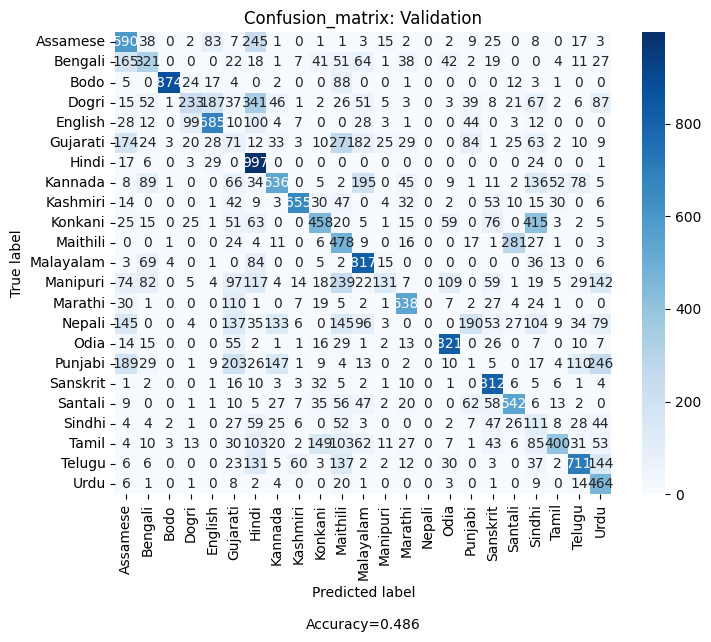

:::::Total vlidation loss 2.7199508481921413, Training accuracy 0.7399310413751748, Validation accuracy 0.486061287115875 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 2.5057122707366943, Accuracy:70.0%
Epoch: 25, Batch: 50, Loss: 2.4528114795684814, Accuracy:76.0%
Epoch: 25, Batch: 100, Loss: 2.437243700027466, Accuracy:77.66666666666666%
Epoch: 25, Batch: 150, Loss: 2.45983624458313, Accuracy:76.0%
Epoch: 25, Batch: 200, Loss: 2.451688766479492, Accuracy:76.33333333333333%
Epoch: 25, Batch: 250, Loss: 2.439568519592285, Accuracy:77.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 2.679678201675415, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 25, Batch: 50, Loss: 2.702634334564209, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 100, Loss: 3.0809926986694336, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 25, Batch: 150, Loss: 2.431975841522217, Accuracy:78.125%
#####TEST--in-domain:::::Epoch: 25, Batch: 2

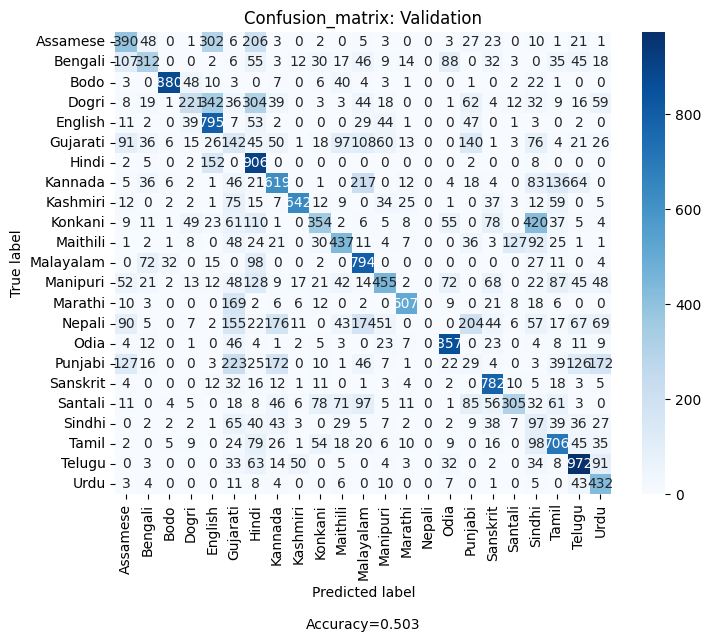

:::::Total vlidation loss 2.7043762944679894, Training accuracy 0.7586073355986408, Validation accuracy 0.5028309633919695 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 26, Batch: 0, Loss: 2.4498369693756104, Accuracy:76.0%
Epoch: 26, Batch: 50, Loss: 2.4931528568267822, Accuracy:71.0%
Epoch: 26, Batch: 100, Loss: 2.4462671279907227, Accuracy:76.66666666666667%
Epoch: 26, Batch: 150, Loss: 2.4332594871520996, Accuracy:77.66666666666666%
Epoch: 26, Batch: 200, Loss: 2.435960292816162, Accuracy:77.33333333333333%
Epoch: 26, Batch: 250, Loss: 2.450495719909668, Accuracy:76.66666666666667%
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 2.673440933227539, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 26, Batch: 50, Loss: 2.7370975017547607, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 26, Batch: 100, Loss: 3.0522961616516113, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 26, Batch: 150, Loss: 2.472555637359619, Accuracy:71.875%
#####TES

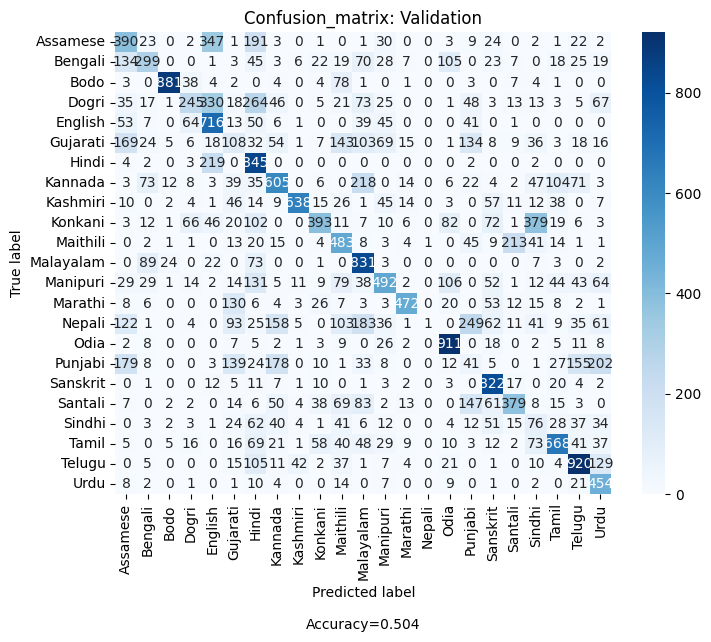

:::::Total vlidation loss 2.7020005445454003, Training accuracy 0.7656406156306216, Validation accuracy 0.5043869127371742 after 26 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 27, Batch: 0, Loss: 2.442680597305298, Accuracy:76.66666666666667%
Epoch: 27, Batch: 50, Loss: 2.4375767707824707, Accuracy:76.66666666666667%
Epoch: 27, Batch: 100, Loss: 2.428260564804077, Accuracy:77.33333333333333%
Epoch: 27, Batch: 150, Loss: 2.4808945655822754, Accuracy:72.66666666666667%
Epoch: 27, Batch: 200, Loss: 2.4776699542999268, Accuracy:73.0%
Epoch: 27, Batch: 250, Loss: 2.4234955310821533, Accuracy:79.66666666666666%
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 2.8263652324676514, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 27, Batch: 50, Loss: 2.6230485439300537, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 27, Batch: 100, Loss: 3.1016383171081543, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 27, Batch: 150, Loss: 2.50884747505188, Accuracy:68.75%

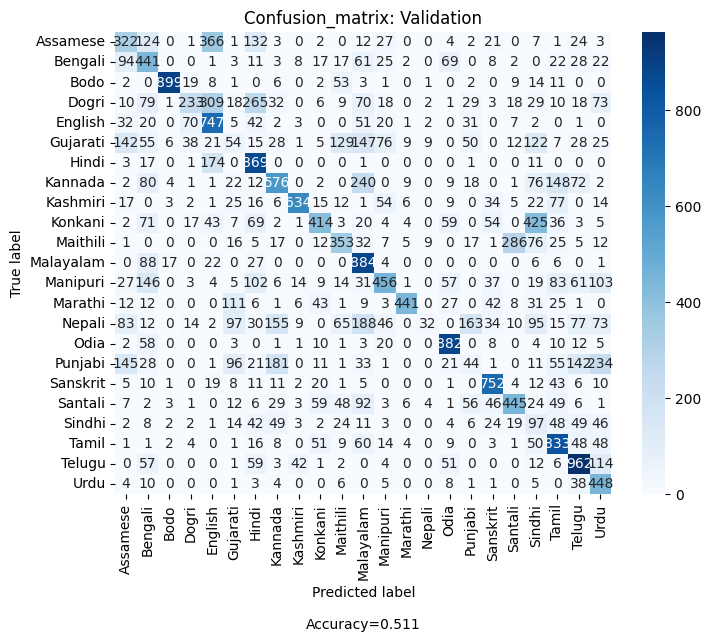

:::::Total vlidation loss 2.696635716527865, Training accuracy 0.7695382770337797, Validation accuracy 0.5107835933785712 after 27 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 28, Batch: 0, Loss: 2.4638283252716064, Accuracy:74.0%
Epoch: 28, Batch: 50, Loss: 2.458042621612549, Accuracy:75.0%
Epoch: 28, Batch: 100, Loss: 2.4179272651672363, Accuracy:80.0%
Epoch: 28, Batch: 150, Loss: 2.455408811569214, Accuracy:74.33333333333333%
Epoch: 28, Batch: 200, Loss: 2.4264299869537354, Accuracy:78.33333333333333%
Epoch: 28, Batch: 250, Loss: 2.5200819969177246, Accuracy:67.66666666666666%
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 2.7723348140716553, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 28, Batch: 50, Loss: 2.6940512657165527, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 28, Batch: 100, Loss: 3.0966594219207764, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 28, Batch: 150, Loss: 2.3303780555725098, Accuracy:90.625%
#####TEST--in-domain::

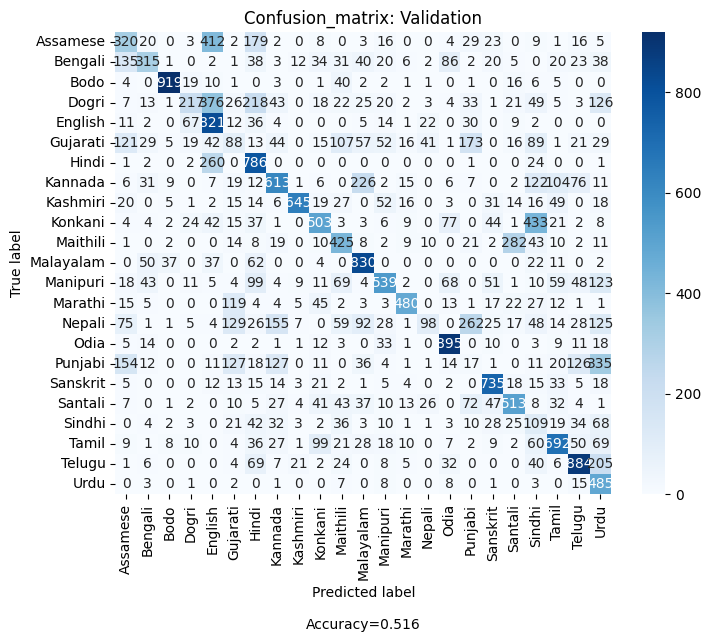

:::::Total vlidation loss 2.6912063123112886, Training accuracy 0.7728737757345593, Validation accuracy 0.5155811038596188 after 28 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 29, Batch: 0, Loss: 2.444427013397217, Accuracy:75.66666666666667%
Epoch: 29, Batch: 50, Loss: 2.4457573890686035, Accuracy:76.0%
Epoch: 29, Batch: 100, Loss: 2.4610073566436768, Accuracy:75.33333333333333%
Epoch: 29, Batch: 150, Loss: 2.434436559677124, Accuracy:77.0%
Epoch: 29, Batch: 200, Loss: 2.392242431640625, Accuracy:82.33333333333334%
Epoch: 29, Batch: 250, Loss: 2.4065284729003906, Accuracy:80.66666666666666%
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 2.8432724475860596, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 29, Batch: 50, Loss: 2.653761625289917, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 29, Batch: 100, Loss: 3.1158607006073, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 29, Batch: 150, Loss: 2.4512758255004883, Accuracy:75.0%
#####TEST--in-dom

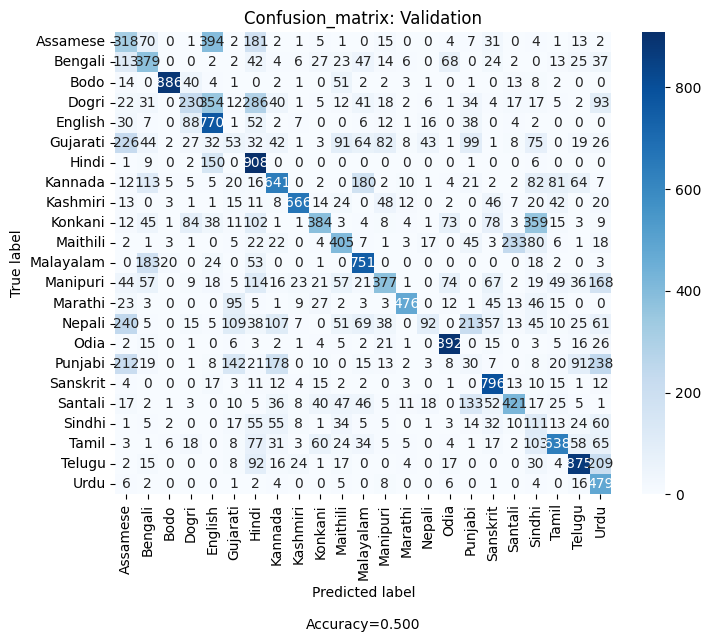

:::::Total vlidation loss 2.706524618752095, Training accuracy 0.7769088546871877, Validation accuracy 0.5004105977438734 after 29 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 30, Batch: 0, Loss: 2.3746089935302734, Accuracy:84.0%
Epoch: 30, Batch: 50, Loss: 2.4249188899993896, Accuracy:78.33333333333333%
Epoch: 30, Batch: 100, Loss: 2.432560682296753, Accuracy:77.66666666666666%
Epoch: 30, Batch: 150, Loss: 2.4110050201416016, Accuracy:79.33333333333333%
Epoch: 30, Batch: 200, Loss: 2.422900438308716, Accuracy:78.0%
Epoch: 30, Batch: 250, Loss: 2.4038314819335938, Accuracy:79.66666666666666%
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 2.837747573852539, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 30, Batch: 50, Loss: 2.6354148387908936, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 30, Batch: 100, Loss: 3.168525457382202, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 30, Batch: 150, Loss: 2.3940248489379883, Accuracy:81.25%
#####TEST--in-

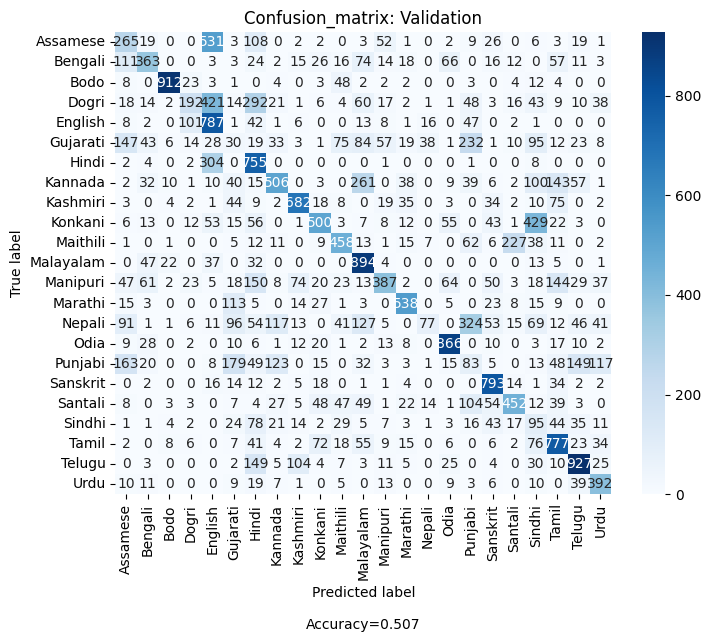

:::::Total vlidation loss 2.6992309146164533, Training accuracy 0.7814436338197082, Validation accuracy 0.5070233824609932 after 30 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 31, Batch: 0, Loss: 2.3894126415252686, Accuracy:83.0%
Epoch: 31, Batch: 50, Loss: 2.466599225997925, Accuracy:74.0%
Epoch: 31, Batch: 100, Loss: 2.422191858291626, Accuracy:78.0%
Epoch: 31, Batch: 150, Loss: 2.4007885456085205, Accuracy:81.0%
Epoch: 31, Batch: 200, Loss: 2.4626996517181396, Accuracy:74.33333333333333%
Epoch: 31, Batch: 250, Loss: 2.400972843170166, Accuracy:80.33333333333333%
#####TEST--in-domain:::::Epoch: 31, Batch: 0, Loss: 2.8600735664367676, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 31, Batch: 50, Loss: 2.6167337894439697, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 31, Batch: 100, Loss: 3.0487592220306396, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 31, Batch: 150, Loss: 2.4668948650360107, Accuracy:75.0%
#####TEST--in-domain:::::Epoch: 31, 

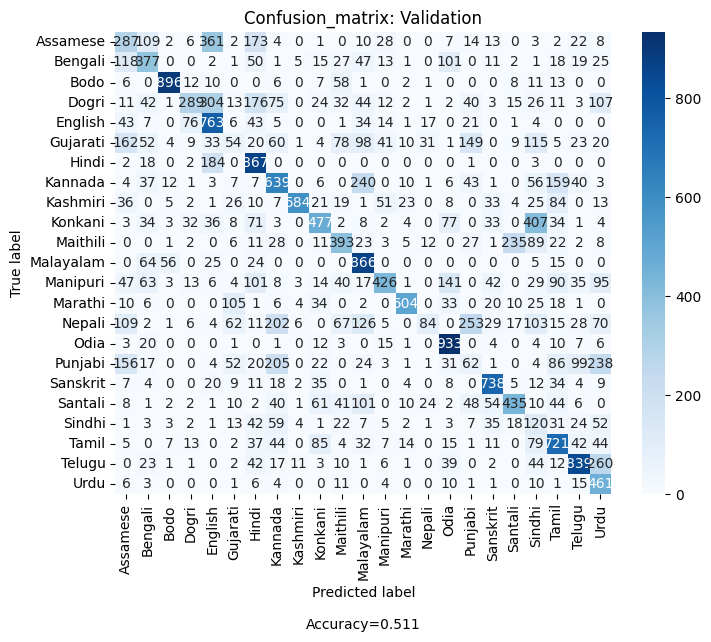

:::::Total vlidation loss 2.696049374440757, Training accuracy 0.786078352988207, Validation accuracy 0.5106539309331374 after 31 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 32, Batch: 0, Loss: 2.425459861755371, Accuracy:79.33333333333333%
Epoch: 32, Batch: 50, Loss: 2.376005172729492, Accuracy:84.33333333333334%
Epoch: 32, Batch: 100, Loss: 2.4287383556365967, Accuracy:77.66666666666666%
Epoch: 32, Batch: 150, Loss: 2.4014623165130615, Accuracy:80.66666666666666%
Epoch: 32, Batch: 200, Loss: 2.4379019737243652, Accuracy:76.66666666666667%
Epoch: 32, Batch: 250, Loss: 2.407771348953247, Accuracy:80.66666666666666%
#####TEST--in-domain:::::Epoch: 32, Batch: 0, Loss: 2.7315707206726074, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 50, Loss: 2.7317795753479004, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 32, Batch: 100, Loss: 3.075944662094116, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 32, Batch: 150, Loss: 2.4270107746124268, Accur

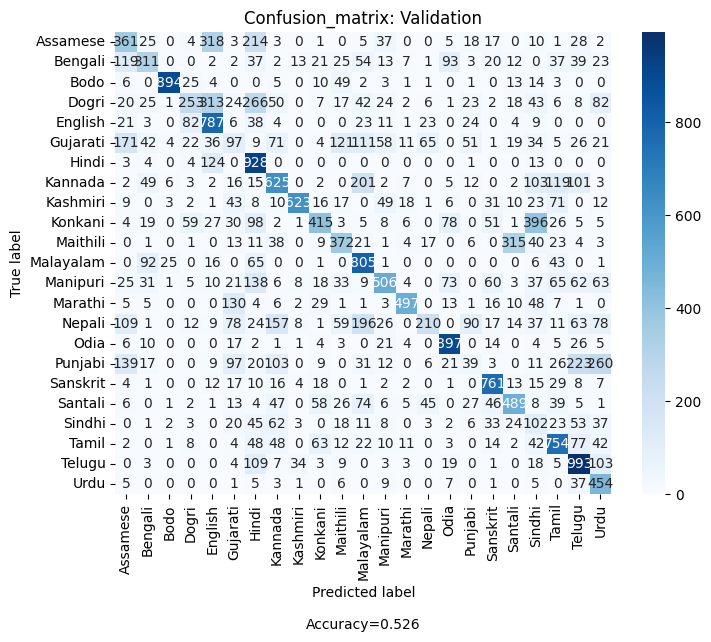

:::::Total vlidation loss 2.681249838836944, Training accuracy 0.7895887467519488, Validation accuracy 0.5261269827548948 after 32 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 33, Batch: 0, Loss: 2.4185869693756104, Accuracy:79.0%
Epoch: 33, Batch: 50, Loss: 2.3836467266082764, Accuracy:82.66666666666667%
Epoch: 33, Batch: 100, Loss: 2.428840160369873, Accuracy:77.33333333333333%
Epoch: 33, Batch: 150, Loss: 2.4348247051239014, Accuracy:77.0%
Epoch: 33, Batch: 200, Loss: 2.391186475753784, Accuracy:82.0%
Epoch: 33, Batch: 250, Loss: 2.4184796810150146, Accuracy:79.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 0, Loss: 2.6675643920898438, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 33, Batch: 50, Loss: 2.7109882831573486, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 100, Loss: 3.107957601547241, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 33, Batch: 150, Loss: 2.432563543319702, Accuracy:78.125%
#####TEST--in-domain:::::Epoch: 33, Ba

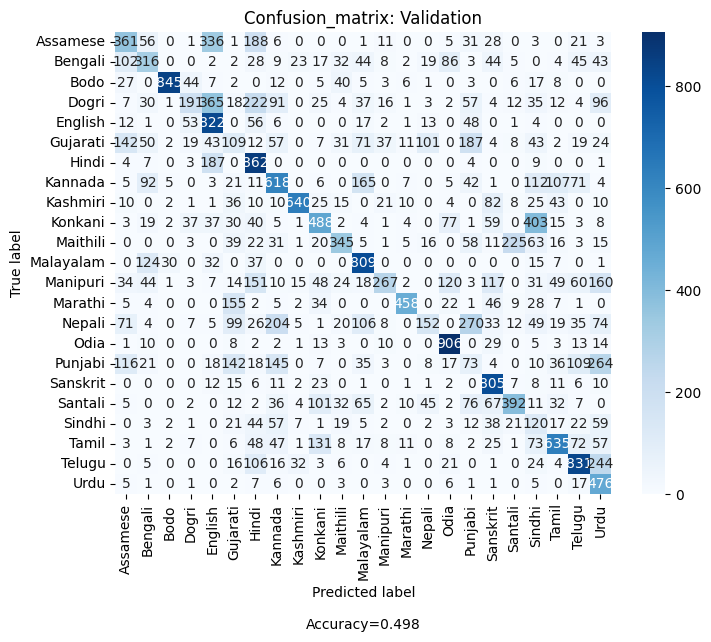

:::::Total vlidation loss 2.7080714294264987, Training accuracy 0.7949980011992804, Validation accuracy 0.49794701128063273 after 33 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 34, Batch: 0, Loss: 2.3824312686920166, Accuracy:82.66666666666667%
Epoch: 34, Batch: 50, Loss: 2.4187283515930176, Accuracy:80.0%
Epoch: 34, Batch: 100, Loss: 2.438614845275879, Accuracy:77.33333333333333%
Epoch: 34, Batch: 150, Loss: 2.4174609184265137, Accuracy:78.33333333333333%
Epoch: 34, Batch: 200, Loss: 2.4535036087036133, Accuracy:76.0%
Epoch: 34, Batch: 250, Loss: 2.4057371616363525, Accuracy:80.33333333333333%
#####TEST--in-domain:::::Epoch: 34, Batch: 0, Loss: 2.81860089302063, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 34, Batch: 50, Loss: 2.64072585105896, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 34, Batch: 100, Loss: 3.1063530445098877, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 34, Batch: 150, Loss: 2.390303134918213, Accuracy:78.125%
#####TEST--i

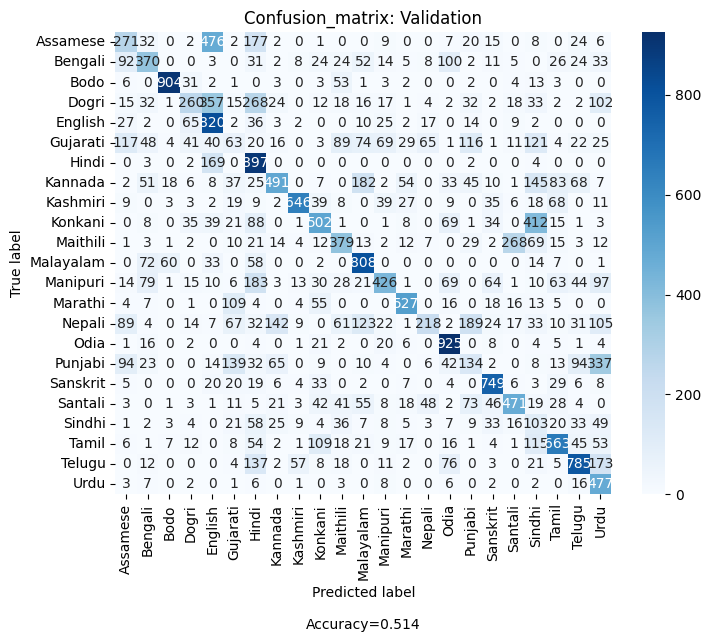

:::::Total vlidation loss 2.6921993849685837, Training accuracy 0.7987707375574655, Validation accuracy 0.5138522712538358 after 34 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 35, Batch: 0, Loss: 2.407099485397339, Accuracy:80.33333333333333%
Epoch: 35, Batch: 50, Loss: 2.417473554611206, Accuracy:80.33333333333333%
Epoch: 35, Batch: 100, Loss: 2.387371778488159, Accuracy:82.66666666666667%
Epoch: 35, Batch: 150, Loss: 2.409403085708618, Accuracy:80.0%
Epoch: 35, Batch: 200, Loss: 2.429572105407715, Accuracy:77.0%


KeyboardInterrupt: 

In [12]:
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/test_23_lang/"
os.makedirs(dest_path,exist_ok=True)
Languages=["Assamese", "Bengali", "Bodo", "Dogri", "English", "Gujarati", "Hindi", "Kannada",
             "Kashmiri", "Konkani", "Maithili", "Malayalam", "Manipuri", "Marathi", "Nepali",
             "Odia", "Punjabi", "Sanskrit", "Santali", "Sindhi", "Tamil", "Telugu", "Urdu"]

def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data 
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        _,_,pred_logits = model(features,torch.LongTensor([len(labels)]).to(device))
        loss = loss_fun(pred_logits,labels)
        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(pred_logits.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=minmax(features)
            features, labels = features.to(device).float(),labels.to(device).long()
            _,_,pred_logits = model(features,torch.LongTensor([len(labels)]).to(device))
            #print(features.shape)
            #print(labels.shape)
            loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(pred_logits.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)
            
        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path, 'Conformer_XV_CD_mfcc_first_pooling_40_128_10_'+str(epoch)+'_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return np.mean(np.array(val_loss_list))

if __name__ == '__main__':
     for epoch in range(40):
            mean_acc = train(trainloader,epoch)
            val_loss = validation(testloader1,epoch,mean_acc)
            scheduler.step(val_loss)
            #testing(testloader2,epoch,mean_acc)
            #testing(testloader3,epoch,mean_acc)